# ANLP FINAL PROJECT - Models tuning

## Content
In this note book you will be able to find the training, the tuning and the evaluation of simple linear neural networ, LSTM network (Pytorch & Keras). This code should be able to work on google collab by adding these two line at the begining of the Notebook : 
```python
from google.colab import drive
drive.mount('/content/drive/')
```
This line with link your Google drive to Google collabs.

A folder with around ~3GB of datas will be created, so you may want to use a new google account.


## How to use 

* Using torch 1.3.1 (a cell installing it)
* Having the files snli_1.0_test/dev/train.jsonl in the same directory of the notebook (or ANLP_FINAL_PROJECT folder on Google drive root)
* Run all cells

On Gihub, a zipfile named "models.zip" contain all history of our models execution (used to create plot) but you can let the notebook create a new one.





## Initialisation, import & downloading

In [1]:
# This part of code is onlt working on google collab (with mounted disk)
import os
try:
  os.chdir('drive/MyDrive')
  try :
    os.mkdir('ANLP_FINAL_PROJECT')
  except:
    pass
  os.chdir('ANLP_FINAL_PROJECT')
except :
  pass
os.listdir()

['.vscode',
 'snli_1.0_train.jsonl',
 'glove.6B.50d.txt',
 'snli_1.0_train.txt',
 'glove.6B.zip',
 'ANLP_final_NNold.ipynb',
 'snli_1.0.zip',
 '__MACOSX',
 'snli_1.0_test.jsonl',
 'glove.6B.100d.txt',
 'snli_1.0_test.txt',
 'glove.6B.300d.txt',
 'snli_1.0_dev.txt',
 'glove.6B.200d.txt',
 'README.md',
 'snli_1.0',
 'snli_1.0_dev.jsonl',
 'word_vector_edit_distance.py',
 'models',
 'anlp.txt']

In [2]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip

File ‘glove.6B.zip’ already there; not retrieving.



In [3]:
!wget -nc https://nlp.stanford.edu/projects/snli/snli_1.0.zip

File ‘snli_1.0.zip’ already there; not retrieving.



In [4]:
!pip install torch==1.3.1

In [5]:
!unzip -n glove.6B.zip

Archive:  glove.6B.zip


In [6]:
!unzip -n snli_1.0.zip

Archive:  snli_1.0.zip


In [7]:
import numpy as np
import pandas as pd
# import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import itertools
import nltk
import torch
import torch.nn as nn
import os
import math
import json
import datetime
import matplotlib.pyplot as plt


## Data pre-processing

In [8]:
# Converting jsonl into pandas 
test_set_raw  = pd.read_json(path_or_buf='./snli_1.0_test.jsonl' , lines=True)
dev_set_raw   = pd.read_json(path_or_buf='./snli_1.0_dev.jsonl'  , lines=True) 
train_set_raw = pd.read_json(path_or_buf='./snli_1.0_train.jsonl', lines=True)

In [9]:
def encode_label(df):
  df = df[['sentence1', 'sentence2', 'gold_label']]
  lb = LabelEncoder()
  df = df[(df['gold_label'] == 'neutral') | (df['gold_label'] == 'contradiction') | (df['gold_label'] == 'entailment')]
  df['labels'] = lb.fit_transform(df['gold_label'])
  classes_names = lb.classes_
  df.drop('gold_label', axis = 1,  inplace= True)
  return df, classes_names

test_set , labels =  encode_label(test_set_raw)
train_set, labels =  encode_label(train_set_raw)
dev_set  , labels =  encode_label(dev_set_raw)

In [10]:
def Embedding_dict(path):
  emb_dct = {}
  with open(path) as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      emb_dct[word] = coefs
  print(f"Number of words found are {len(emb_dct)}")
  return emb_dct
dct = Embedding_dict("glove.6B.300d.txt")

Number of words found are 400000


In [11]:
def create_dataset(df, dct, func = 'sum', emb_dim = 300):
  embedding_matrix = np.zeros((df.shape[0], 2*emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = []
    vec2 = []
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for w1, w2 in list(itertools.zip_longest(s1, s2, fillvalue='foo')):
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1.append(check1)
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2.append(check1)
          hit+=1
        else:
          miss+=1
    ##
    vec1 = np.asarray(vec1)
    vec2 = np.asarray(vec2)
    if func == "sum":
      vec1 = np.sum(vec1, axis = 0)
      vec2 = np.sum(vec2, axis = 0)
    if func == "mean":
      vec1 = np.mean(vec1, axis = 0)
      vec2 = np.mean(vec2, axis = 0)
    #print("vec1 ", vec1.shape, "vec2 shape ", vec2.shape, "i is ", i)
    embedding_matrix[i, :] = np.concatenate((vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return embedding_matrix, labels    

In [12]:
def create_dataset_for_sequence(df, dct, emb_dim = 300, seq_len = 20):
  sequence_matrix = np.zeros((df.shape[0], seq_len*2 ,emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = np.zeros((seq_len, emb_dim))
    vec2 = np.zeros((seq_len, emb_dim))
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for j, (w1, w2) in enumerate(list(itertools.zip_longest(s1, s2, fillvalue='foo'))):
      if j>= seq_len:
        break
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1[j, :] = check1
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2[j, :] = check1
          hit+=1
        else:
          miss+=1
    sequence_matrix[i, :, :] = np.concatenate((vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return sequence_matrix, labels    

## Simple linear network

In [13]:
class simple_model(nn.Module):
  

  def __init__(self, argjs):
    super(simple_model, self).__init__()
    def check_args(aj):
        default_args = {
            'batch_size' : 64,
            'epochs' : 1000,
            'lr' : 0.007,
        }

        for k in default_args:
            if not (k in aj):
                aj[k] = default_args[k] 

        return aj
    
    aj = check_args(argjs)

    self.batch_size = aj['batch_size']
    self.epochs     = aj['epochs']
    self.lr         = aj['lr']

    self.fc1 = nn.Linear(600, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 3)


    self.relu = nn.ReLU()

    
    

  def forward(self, embedding_matrix):
    x = self.fc1(embedding_matrix)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)

    return x

  def train_model(self, embedding_matrix, labels):

    batch_size  =   self.batch_size
    epochs      =   self.epochs
    lr          =   self.lr

    self.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) 
    self.zero_grad()
    view = 0

    global_loss = []
    acc= []
    for epoch in range(epochs+1):
      l = []
      for i in range(embedding_matrix.shape[0]//batch_size):
        optimizer.zero_grad()
        inp = embedding_matrix[i*batch_size: (i*batch_size + batch_size), :]
        lab = labels[i*batch_size: (i*batch_size + batch_size)]
        out = self(inp)

        loss = criterion(out, lab)
        ypred = torch.argmax(out, dim = 1)
        ypred = ypred.numpy()
        acc.append(np.sum(ypred == lab.numpy())/len(lab.numpy()))
        view += 1
      

        loss.backward()
        optimizer.step()
        l.append(loss.detach().item())
      global_loss += l

      if epoch%(epochs/10) == 0:
        print("loss is ", global_loss[-1], ' at ', epoch, 'accuracy :', sum(acc)/(len(acc) if len(acc) != 0 else 1) )
    
    return global_loss, acc

## LSTM Network

In [14]:
# Mylstm(batch_size= 1, hidden_size= 30, num_classes= 3, num_layers= 1, embedding_dim= 300)

import gc
class Mylstm(nn.Module):

    def check_args(self, aj):
        default_args = {
            'batch_size' : 32,
            'hidden_size' : 64,
            'num_classes' : 3,
            'num_layers' : 1,
            'embedding_dim' : 300,
            'epochs' : 10,
            'lr' : 0.005,
        }

        for k in default_args:
            if not (k in aj):
                aj[k] = default_args[k] 

        return aj

    def __init__(self, argsJson):
        super(Mylstm, self).__init__()

        # Checking arguments
        aj = self.check_args(argsJson)
        
        # LSTM network init
        self.batch_size     =   aj['batch_size']
        self.hidden_size    =   aj['hidden_size']
        self.num_classes    =   aj['num_classes']
        self.num_layers     =   aj['num_layers']
        self.embedding_dim  =   aj['embedding_dim']

        # Train parameters init
        self.epochs         =   aj['epochs']
        self.lr             =   aj['lr']
        self.batch_size     =   aj['batch_size']

        # Saving parameters
        self.aj = aj

        # No sensitive layer because already done by the embedding part.
        self.lstm = nn.LSTM(input_size= self.embedding_dim, hidden_size= self.hidden_size, num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)


    def forward(self, x):
        out, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
        out = self.fc(out[:, -1, :])
        return out

  
    def init_hidden(self):
        self.h0 = torch.rand(self.num_layers, self.batch_size, self.hidden_size)
        self.c0 = torch.rand(self.num_layers, self.batch_size, self.hidden_size)


    def train_model(self, seq, labels):
        epochs      =   self.epochs
        lr          =   self.lr
        batch_size  =   self.batch_size

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr= lr)
        all_loss = []
        acc = []
        for epoch in range(epochs):
            l = []
            self.init_hidden()
            
            for i in range(batch_size, seq.shape[0], batch_size):
                self.zero_grad()
                xtrain = seq[i-batch_size: i,:,:]
                target = labels[i-batch_size: i]
                self.train()
                optimizer.zero_grad()
                out = self(xtrain)

                ypred = torch.argmax(out, dim = 1)
                ypred = ypred.numpy()
                acc.append(np.sum(ypred == target.numpy())/len(target.numpy()))

                loss = criterion(out, target)
                loss.backward(retain_graph=True)
                optimizer.step()
                l.append(loss.detach().item())

            all_loss += l

            if epoch == epoch:
                print("loss is ", all_loss[-1], ' at ',epoch , 'accuracy :', sum(acc)/(len(acc) if len(acc) != 0 else 1) )
        return all_loss, acc
              
          

## Keras tensor LSTM

We choose to also create a model with Keras because training Keras was easier and faster.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import History

In [16]:

train_matrix , train_label = create_dataset_for_sequence(train_set.head(10), dct)
val_matrix, val_label = create_dataset_for_sequence(dev_set, dct)

The number of hits are 198 and the number of miss are 0
The number of hits are 220040 and the number of miss are 513


In [17]:
class lstm_keras:
    def __init__(self, argsJson):
        def check_args( aj):
            default_args = {
                'batch_size' : 32,
                'hidden_size' : 64,
                'epochs' : 10,
                'lr' : 0.005,
                'drop_rate' : 0.2,
                'drop_out' : False
            }

            for k in default_args:
                if not (k in aj):
                    aj[k] = default_args[k] 

            return aj


        aj = check_args(argsJson)

        self.bs = aj['batch_size']
        self.drop_rate = aj['drop_rate']
        self.epochs = aj['epochs']
        self.lr = aj['lr']
        self.hidden_size = aj['hidden_size']
        self.drop_out = aj['drop_out']
        self.drop_rate = aj['drop_rate']

        self.aj = aj

        inp = Input(shape = (40, 300))
        lstm = LSTM(self.hidden_size)(inp)
        print(self.drop_out)
        if self.drop_out:
            do = Dropout(self.drop_rate)(lstm)
            fc = Dense(3)(do)
        else :
            fc = Dense(3)(lstm)
        self.model = tf.keras.Model(inputs = inp, outputs = fc)

    def train_model(self, embedding_matrix, label, val_matrix, val_label):
        opt = keras.optimizers.Adam(learning_rate=self.lr)
        self.model.compile(optimizer = opt, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True), metrics = ['accuracy'])
        self.history = self.model.fit(embedding_matrix, label, epochs = self.epochs, batch_size= self.bs, validation_data=(val_matrix, val_label))
        self.history = self.history.history
        return self.history['accuracy'], self.history['accuracy']

    
    def __call__(self, input_x): 
        if 'torch' in str(type(input_x)):
            return self.model(input_x.numpy()).numpy()
        else :
            return self.model(input_x).numpy()
        
        

## Hyper parameters tunning 

In [18]:
"""
Function : kfold

param : data (tensor, list ...) -> data to split
param : size (int) -> fold length

@description
This function will transform a dataset into list of part of the dataset
"""

def kfold(data, size):
    ret = []
    mem = 0
    for i in range(0, len(data)):
        if i-mem == size:
            ret.append(data[mem:i])
            mem = i

    ret.append(data[mem:(len(data))])
    return ret

In [19]:
"""
Function : cartesianProduct

@param : l -> list of list of param
@param : parameter_name -> list of string

@description
This function will shuffle all the list of list to obtain all the combinaison of possibles parameter set
"""
def cartesianProduct(l, parameter_name = []):
    if len(l) == 1 :
        return l[0]
    if len(l) == 0 :
        return []

    def baseCartesianProduct(l1,l2):
        ret = []
        for i in l1 :
            for j in l2 : 
                if type(i) != type([]):
                    ret.append([i,j]) 
                else:
                    mem = []
                    for e in i :
                        mem.append(e)
                    mem.append(j) 
                    ret.append(mem)
        return ret
    ret = baseCartesianProduct(l[0],l[1])
    for k in range (2, len(l)):
        ret = baseCartesianProduct(ret, l[k])
    
    if len(parameter_name) != 0:
        
        for i in range(len(ret)):
            mem = {}
            for j in range(len(parameter_name)):
                mem[parameter_name[j]] = ret[i][j]
            ret[i] = mem
    return ret

In [20]:
"""
Function findArgumentsSet

@param : data -> json that contain all the models and their args 
@param : argSet -> the dictionnary to find in in the data

@description 
This function return the model description in the varable data if their is a model that have the same parameters as described in the variable argSet
"""
def findArgumentsSet(data, argSet):
    for mod in data:
        if argSet == mod['args']:
            return mod
    return None



"""
Function gridTunning

@param modelFun -> Pytorch neural network constructor
@param listArg -> The list of json that describe the parameters that will be pass to the model
@param data -> training data (tensor)
@param test -> testing data
@param kfold_size -> the size of each fold @see function kfold 
@param dct -> gloves dictionnary
@param model_type -> string that describe the type of the model

@description
This function will execute models with a lot of different set of parameters described in the param listArg and save all the information for the post dataprocessing,
this function also save models that you can load with the connamd nn.load(model_name)

"""
def gridTuning(modelfun, listArg, data, test, kfold_size, dct, model_type):

    print('Folding dataset.')
    kfold_list = kfold(data, kfold_size)
    print('Done.')
    narg = 0

    try :
        os.mkdir('models')
    except :
        print('Dir already created')

    overviewdata = None
    try :
        with open('models/overview.json') as json_file:
            overviewdata = json.load(json_file)
    except:
        open('models/overview.json', 'w').close()
        overviewdata = []


    if model_type == 'lstm' :
        print('Creating test dataset with sequences - torch')

        xte, yte = create_dataset_for_sequence(test, dct)
        xte = torch.tensor(xte).float()
        yte = torch.tensor(yte).type(torch.LongTensor)  
        yte = yte.numpy()
    elif model_type == 'simple' :
        print('Creating test dataset without sequences')
        xte, yte = create_dataset(test, dct)
        xte = torch.tensor(xte).float()
        yte = torch.tensor(yte).type(torch.LongTensor)  
        yte = yte.numpy()
    elif model_type == 'keras':
        print('Creating test dataset with sequences - keras')
        xte, yte = create_dataset_for_sequence(test, dct)

    print('Done.')
  
    all_acc = []



    while narg < len(listArg):
        for fold in kfold_list:

            if narg >= len(listArg):
              return
            listArg[narg]['fold_size'] = len(fold)
            preMod = findArgumentsSet(overviewdata, listArg[narg])
            if preMod == None :
              x = datetime.datetime.now()
              name = (str(x.month) if x.month >=10 else '0' + str(x.month)) + '-'  + (str(x.day) if x.day >=10 else '0' + str(x.day))+ '-'   + (str(x.hour) if x.hour >=10 else '0' + str(x.hour))+ '-' + (str(x.minute) if x.minute >=10 else '0' + str(x.minute))+ '-'  + (str(x.second) if x.second >=10 else '0' + str(x.second)) 

              print('\n'+ str(narg+1) + '/' + str(len(listArg)) + ' | Training model' + name + ' | ' + str(listArg[narg]))
              if model_type == 'lstm' :
                df_dataset, label = create_dataset_for_sequence(fold, dct)
                df_dataset = torch.tensor(df_dataset).float()
                label = torch.tensor(label).type(torch.LongTensor)
              elif model_type == 'simple' :
                df_dataset, label = create_dataset(fold, dct)
                df_dataset = torch.tensor(df_dataset).float()
                label = torch.tensor(label).type(torch.LongTensor)
              elif model_type == 'keras' :
                df_dataset, label = create_dataset_for_sequence(fold, dct)

              copy_la = listArg[narg].copy()


              #creating model and training it
              model = modelfun(listArg[narg])
              if model_type == 'keras':
                  train_losses, train_acc = model.train_model(df_dataset, label, xte , yte)
              else :
                  train_losses, train_acc = model.train_model(df_dataset, label)
              # Evaluating model 
              
              print('Start testing...')
              acc = 0
              if model_type == 'lstm' :
                    accu = []
                    batch_size = model.batch_size
                    for i in range(batch_size, xte.shape[0], batch_size):
                        
                        xtest = xte[i-batch_size: i,:,:]
                        target = yte[i-batch_size: i]
                        out = model(xtest)
                        ypred = torch.argmax(out, dim = 1)
                        ypred = ypred.numpy()
                        # print(ypred)
                        accu.append(np.sum(ypred == target)/len(target))
                    # print(accu)
                    acc = sum(accu)/len(accu)
              elif model_type == 'simple' :
                  ypred = model(xte)
                  ypred = torch.argmax(ypred, dim = 1)
                  ypred = ypred.numpy()
                  acc = np.sum(ypred == yte)/len(yte) 
              elif model_type == 'keras' :
                  ypred = model(xte)
                  ypred = torch.argmax(torch.from_numpy(ypred), dim=1)
                  ypred = ypred.numpy()
                  acc = np.sum(ypred == yte)/len(yte) 

              
              print('Testing done.')


              

              ypred = None
              ypred1 = None

              print('Accuracy on this model : ' + str(acc))
              
              copy_la['fold_size'] = len(fold)



              jsonArg = {
                  "model" : "model" + name,
                  "args" : copy_la,
                  "acc" : acc,
                  "train_acc" : train_acc,
                  "train_losses" : train_losses, 
                  "real_param" : listArg[narg],
                  "info" : {"train_length" : len(df_dataset), "test_length": len(yte)},
                  'model_type' : model_type
              }


              overviewdata.append(jsonArg)
              with open('models/overview.json', 'w') as outfile:
                json.dump(overviewdata, outfile)

              if model_type != 'keras' :
                torch.save(model, 'models/model' + name + '.nn')
              df_dataset = None
              model = None
              narg += 1
              
              
            else :
              print('Model already exist with param : ' + str(preMod['args']))
              
              narg += 1
              if narg >= len(listArg):
                  return
          
            

In [21]:
## Creating grid : 

bs = [64]
dr = [0.3]
hs = [128]
lr = [0.003]
epochs = [10]
do = [True]

paramlist = [bs,dr,hs,lr,epochs,do]
param_name = ['batch_size', 'drop_rate', 'hidden_layers', 'lr', 'epochs', 'drop_out']

argjs = cartesianProduct(paramlist, param_name)
print("Number of sets of arguments :", len(argjs))
gridTuning(lstm_keras, argjs, train_set.head(120000), test_set, 120000, dct, 'keras')

Number of sets of arguments : 1
Folding dataset.
Done.
Dir already created
Creating test dataset with sequences - keras
The number of hits are 219292 and the number of miss are 555
Done.

1/1 | Training model03-01-14-28-33 | {'batch_size': 64, 'drop_rate': 0.3, 'hidden_layers': 128, 'lr': 0.003, 'epochs': 10, 'drop_out': True, 'fold_size': 120000}
The number of hits are 2568200 and the number of miss are 5674
True
Epoch 1/10
1875/1875 [==============================] - 87s 47ms/step - loss: 0.8754 - accuracy: 0.5966 - val_loss: 0.7999 - val_accuracy: 0.6436
Epoch 2/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.7791 - accuracy: 0.6559 - val_loss: 0.7764 - val_accuracy: 0.6620
Epoch 3/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.7313 - accuracy: 0.6851 - val_loss: 0.7711 - val_accuracy: 0.6628
Epoch 4/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.6960 - accuracy: 0.7045 - val_loss: 0.7463 - val_accuracy: 0.679

In [31]:
## Creating grid : 

bs = [64]
hs = [32]
nl = [1]
lr = [0.005,0.008]
epochs = [10]

paramlist = [bs,hs,nl,lr,epochs]
param_name = ['batch_size', 'hidden_size', 'num_layers', 'lr', 'epochs']

argjs = cartesianProduct(paramlist, param_name)
print("Number of sets of arguments :", len(argjs))

Number of sets of arguments : 2


In [32]:
gridTuning(Mylstm, argjs, train_set.head(10000), test_set, 10000, dct, 'lstm')

Folding dataset.
Done.
Dir already created
Creating test dataset with sequences - torch
The number of hits are 219292 and the number of miss are 555
Done.

1/2 | Training model03-01-14-49-12 | {'batch_size': 64, 'hidden_size': 32, 'num_layers': 1, 'lr': 0.005, 'epochs': 10, 'fold_size': 10000}
The number of hits are 213877 and the number of miss are 462
loss is  0.9912068247795105  at  0 accuracy : 0.44140625
loss is  0.9480302333831787  at  1 accuracy : 0.47911658653846156
loss is  0.8849906325340271  at  2 accuracy : 0.5072449252136753
loss is  0.869208574295044  at  3 accuracy : 0.5309244791666666
loss is  0.7419762015342712  at  4 accuracy : 0.553926282051282
loss is  0.803862988948822  at  5 accuracy : 0.5750534188034188
loss is  0.73490971326828  at  6 accuracy : 0.5933064331501832
loss is  0.7975637912750244  at  7 accuracy : 0.60986328125
loss is  0.7767519950866699  at  8 accuracy : 0.6236200142450142
loss is  0.6690369844436646  at  9 accuracy : 0.6368489583333333
Start testi

KeyboardInterrupt: 

In [33]:
# Random tuning
import random

"""
Function randomTunning

@param modelFun -> Pytorch neural network constructor
@param listArg -> The list of json that describe the parameters that will be pass to the model
@param data -> training data (tensor)
@param test -> testing data
@param kfold_size -> the size of each fold @see function kfold 
@param dct -> gloves dictionnary
@param nb_set -> the number oflist of parameters that will be randomly choose
@param model_type -> string that describe the type of the model

@description
This function will execute models with a lot of different set of parameters described in the param listArg and save all the information for the post dataprocessing,
this function also save models that you can load with the connamd nn.load(model_name)

"""
def randomTuning(modelfun, listArg, data, test, kfold_size, dct, nb_set, model_type):
  if nb_set > len(listArg) :
    print('Number of set to choose too big')
  else :
      newArgList = []
      for i in range(nb_set):
        rnd = random.randint(0,len(listArg))
        newArgList.append(listArg[rnd])
        listArg.pop(rnd)

      print(newArgList)
      gridTuning(modelfun, newArgList, data, test, kfold_size, dct, model_type)
        
bs = [32, 64 , 128]
hs = [2,  32, 64 ,128]
lr = [0.005, 0.008]
epochs = [10]

paramlist = [bs,hs,nl,lr,epochs]
param_name = ['batch_size', 'hidden_size', 'num_layers', 'lr', 'epochs']

argjs = cartesianProduct(paramlist, param_name)
print("Number of sets of arguments :", len(argjs))



Number of sets of arguments : 24


In [34]:
randomTuning(Mylstm, argjs, df.head(1000), test_set.head, 100, dct, 3, 'lstm')

In [35]:
bs = [16,32,64,128]
lr = [0.005, 0.008, 0.007]
epochs = [100, 500]

paramlist = [bs,lr,epochs]
param_name = ['batch_size',  'lr', 'epochs']

argjs = cartesianProduct(paramlist, param_name)
print("Number of sets of arguments :", len(argjs))
gridTuning(simple_model, argjs, train_set.head(3000), test_set, 100, dct, 'simple')

gridTuning(simple_model, argjs, train_set.head(3000), test_set, 500, dct, 'simple')


Number of sets of arguments : 24


### Outputing the result of the tuning

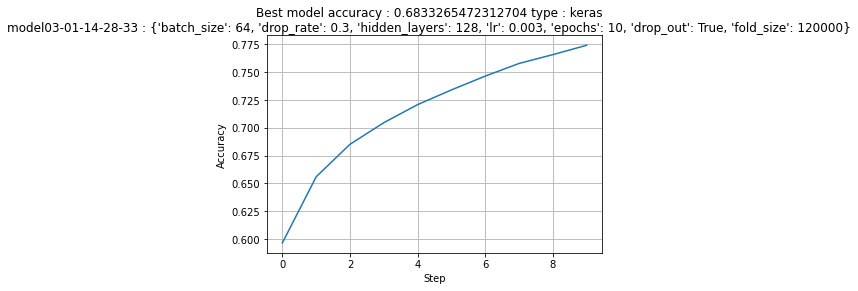

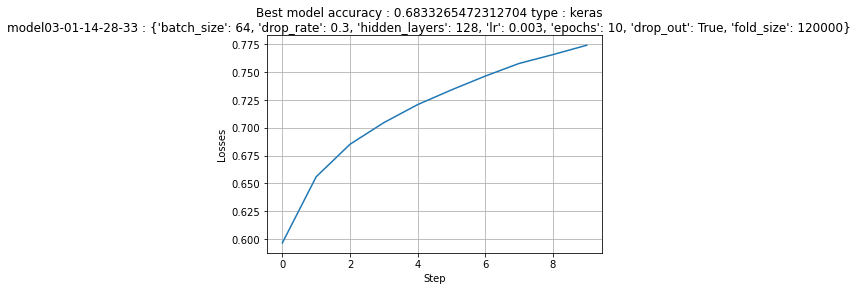

Simple model data


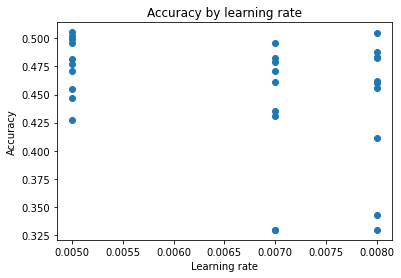

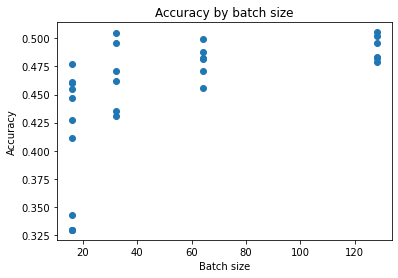

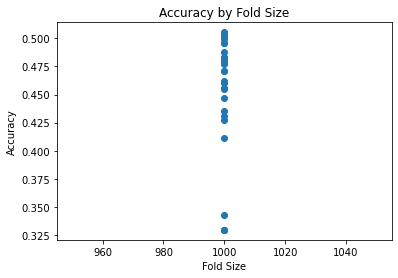

LSTM data


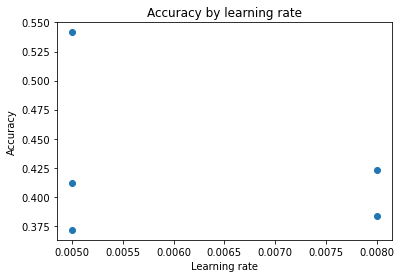

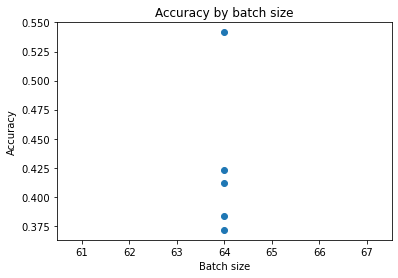

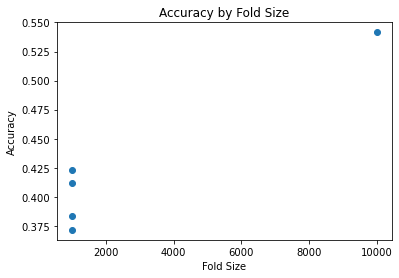

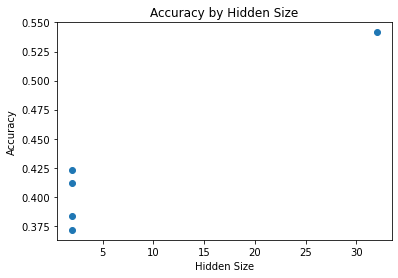

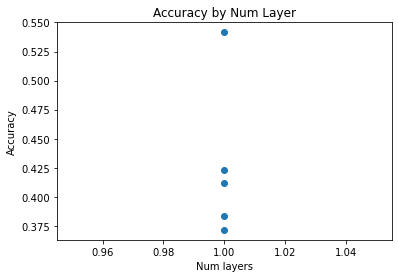

Keras data


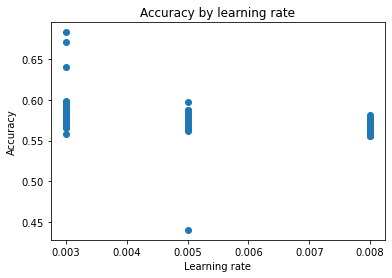

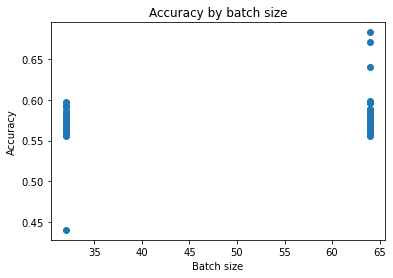

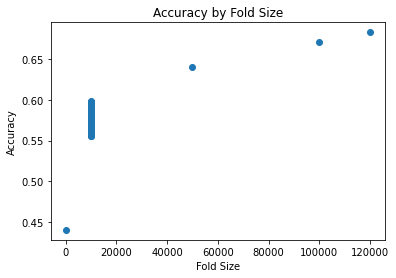

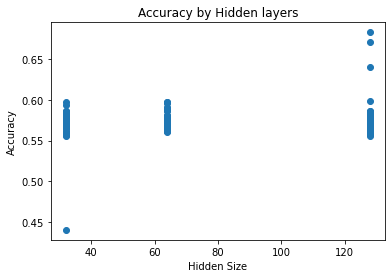

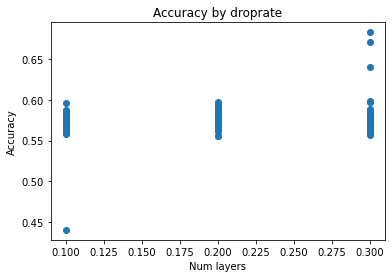

In [40]:
def outputStat():
    overviewdata = None
    try :
        with open('models/overview.json') as json_file:
            overviewdata = json.load(json_file)
    except:
        print("No model have been trained")
        return

    #Best model :
    acc = 0
    best_model = None
    for mod in overviewdata:
        if mod['acc'] > acc :
            acc = mod['acc']
            best_model = mod
    
    name = 'Best model accuracy : ' + str(best_model['acc']) +  ' type : ' + best_model['model_type']+ '\n' + best_model['model'] + ' : ' + str(best_model['args']) 

    plt.plot(range(len(best_model['train_acc'])), best_model['train_acc'])
    plt.grid(True)
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.suptitle(name)

    plt.show()
    plt.plot(range(len(best_model['train_losses'])), best_model['train_losses'])
    plt.grid(True)
    plt.xlabel('Step')
    plt.ylabel('Losses')
    plt.suptitle(name)
    plt.show()


    # Parameters informations
    
    lstm_models = []
    simple_models = []
    keras_models = []
    for mod in overviewdata:
        if mod['model_type'] == 'lstm' :
            lstm_models.append(mod)
        elif mod['model_type'] == 'simple' :
            simple_models.append(mod)
        elif mod['model_type'] == 'keras' :
            keras_models.append(mod)
    # print(lstm_models)

    ## Simple Models
    print("Simple model data")
    ac = []
    hs = []
    nl = []
    lr = []
    bs = []
    fs = []
    for mod in simple_models:
        ac.append(mod['acc'])
        lr.append(mod['args']['lr'])
        bs.append(mod['args']['batch_size'])
        fs.append(mod['args']['fold_size'])

    plt.scatter(lr,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Learning rate')
    plt.title('Accuracy by learning rate')
    plt.show()


    plt.scatter(bs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Batch size')
    plt.title('Accuracy by batch size')
    plt.show()


    plt.scatter(fs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Fold Size')
    plt.title('Accuracy by Fold Size')
    plt.show()

    # LSTM
    print('LSTM data')
    ac = []
    hs = []
    nl = []
    lr = []
    bs = []
    fs = []
    for mod in lstm_models:
        ac.append(mod['acc'])
        lr.append(mod['args']['lr'])
        bs.append(mod['args']['batch_size'])
        fs.append(mod['args']['fold_size'])
        hs.append(mod['args']['hidden_size'])
        nl.append(mod['args']['num_layers'])


    plt.scatter(lr,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Learning rate')
    plt.title('Accuracy by learning rate')
    plt.show()


    plt.scatter(bs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Batch size')
    plt.title('Accuracy by batch size')
    plt.show()


    plt.scatter(fs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Fold Size')
    plt.title('Accuracy by Fold Size')
    plt.show()

    plt.scatter(hs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Hidden Size')
    plt.title('Accuracy by Hidden Size')
    plt.show()

    plt.scatter(nl,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Num layers')
    plt.title('Accuracy by Num Layer')
    plt.show()

    # keras lstm
    print('Keras data')
    ac = []
    hl = []
    dr = []
    lr = []
    bs = []
    fs = []
    for mod in keras_models:
        ac.append(mod['acc'])
        lr.append(mod['args']['lr'])
        bs.append(mod['args']['batch_size'])
        fs.append(mod['args']['fold_size'])
        hl.append(mod['args']['hidden_layers'])
        dr.append(mod['args']['drop_rate'])


    plt.scatter(lr,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Learning rate')
    plt.title('Accuracy by learning rate')
    plt.show()


    plt.scatter(bs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Batch size')
    plt.title('Accuracy by batch size')
    plt.show()


    plt.scatter(fs,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Fold Size')
    plt.title('Accuracy by Fold Size')
    plt.show()

    plt.scatter(hl,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Hidden Size')
    plt.title('Accuracy by Hidden layers')
    plt.show()

    plt.scatter(dr,ac)
    plt.ylabel('Accuracy')
    plt.xlabel('Num layers')
    plt.title('Accuracy by droprate')
    plt.show()
outputStat()